In [65]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"



#| output: false
# 여기에 온갖코드를 넣음.

df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)


tidydata1 = df_feature.pivot_table(
    index = 'dayofweek',
    columns = 'pickup_hour',
    values = 'speed',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'mean_speed'}, axis =1)



df_small = df[::100].reset_index(drop=True)

pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_small2 = df_left.merge(df_right)
tidydata3 = df_small2.sort_values('speed').assign(평균속력 = lambda df: pd.qcut(df.speed,4,labels=['매우느림','조금느림','조금빠름','매우빠름']))


# 1-(1),(2),(3) 에 대응하는 plotly figure를 아래와 같은 이름으로 저장
fig1 = px.density_heatmap(
    data_frame = tidydata1,
    x = 'pickup_hour',
    y = 'dayofweek',
    z = 'mean_speed',
    nbinsx=24,
    nbinsy=7,
    height=300
)

# fig2 = ...

fig3 = px.line_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = '평균속력',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
)
scatter_data = px.scatter_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = '평균속력',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
).data
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)

for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['name'] += ' (path)'
    else:
        fig3.data[i]['name'] += ' (pickup/dropoff)'
    

fig3.show(config={'scrollZoom':False})


# NYCTaxi 1-(1),(2)


#| title: 요일,시간에 따른 평균속력 시각화        
#fig1.show()



#| title: 요일,시간에 따른 평균이동거리 시각화        
#fig2.show()

# NYCTaxi 1-(3)


#| title: 속력별 경로 시각화
#fig3.show()



# 에너지사용량(지리정보시각화) 2-(1)
# 에너지사용량(지리정보시각화) 2-(2)

In [241]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
).assign(dayofweek = lambda df: df.dayofweek.map({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'}))


weekday_order = ['월', '화', '수', '목', '금', '토', '일']
df['dayofweek'] = pd.Categorical(df['dayofweek'], categories=weekday_order, ordered=True)

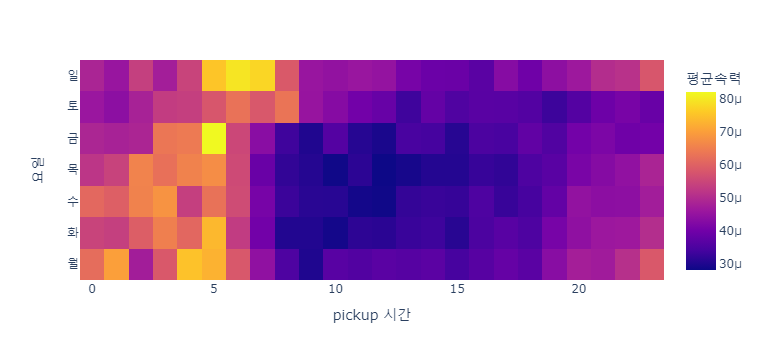

In [264]:
#요일, 시간에 따른 평균속력 시각화 
# dayofweek, pickup_hour, speed_mean
tidydata1 = df.pivot_table(
    index = 'dayofweek',
    columns = 'pickup_hour',
    values = 'speed',
    aggfunc = 'mean'
).stack().reset_index()\
.rename({0:'speed_mean'}, axis =1)

fig1 = px.density_heatmap(
    data_frame = tidydata1,
    x = 'pickup_hour',
    y = 'dayofweek',
    z = 'speed_mean',
    nbinsx=24,
    nbinsy=7,
    height=300
    
)

fig1.update_xaxes(title_text='pickup 시간')
fig1.update_yaxes(title_text='요일')
fig1.update_coloraxes(colorbar_title_text='평균속력')

fig1.show()

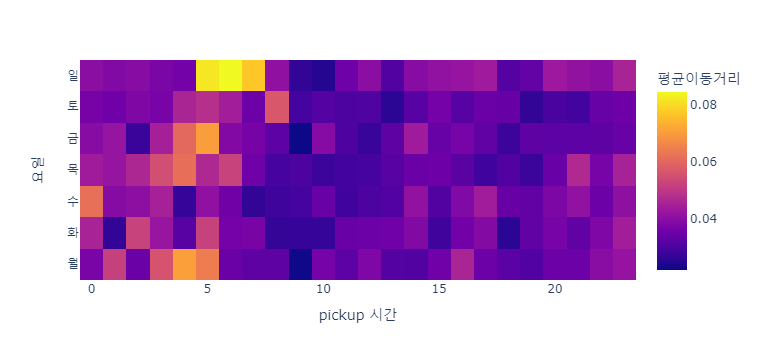

In [263]:
#요일,시간에 따른 평균이동거리 시각화 
tidydata2 = df.pivot_table(
    index = 'dayofweek',
    columns = 'pickup_hour',
    values = 'dist',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'dist_mean'},axis =1)


# layout2 = {
#     'xaxis':{'title':'pickup 시간'},
#     'yaxis':{'title':'요일'},   
# }

fig2 =px.density_heatmap(
    data_frame = tidydata2,
    x = 'pickup_hour',
    y = 'dayofweek',
    z = 'dist_mean',
    nbinsx=24,
    nbinsy=7,
    height=300
)
fig2.update_xaxes(title_text='pickup 시간')
fig2.update_yaxes(title_text='요일')
fig2.update_coloraxes(colorbar_title_text='평균이동거리')

fig2.show()

In [249]:
df_small = df[::100].reset_index(drop=True)
df_small

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,pickup_hour,dropoff_hour,dayofweek
0,id2875421,B,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,0.017680,0.000039,17,17,월
1,id3667993,B,2016-01-03 04:18:57,2016-01-03 04:27:03,1,-73.980522,40.730530,-73.997993,40.746220,N,486,6.186209,0.023482,0.000048,4,4,일
2,id2002463,B,2016-01-14 12:28:56,2016-01-14 12:37:17,1,-73.965652,40.768398,-73.960068,40.779308,N,501,6.216606,0.012256,0.000024,12,12,목
3,id1635353,B,2016-03-04 23:20:58,2016-03-04 23:49:29,5,-73.985092,40.759190,-73.962151,40.709850,N,1711,7.444833,0.054412,0.000032,23,23,금
4,id1850636,A,2016-02-05 00:21:28,2016-02-05 00:52:24,1,-73.994537,40.750439,-74.025719,40.631100,N,1856,7.526179,0.123345,0.000066,0,0,금
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,id0621879,A,2016-04-23 09:31:33,2016-04-23 09:51:33,1,-73.950783,40.743614,-74.006218,40.722729,N,1200,7.090077,0.059239,0.000049,9,9,토
142,id2587483,B,2016-03-28 12:59:58,2016-03-28 13:08:11,2,-73.953903,40.787079,-73.940842,40.792461,N,493,6.200509,0.014127,0.000029,12,13,월
143,id1030598,B,2016-03-03 11:44:24,2016-03-03 11:49:59,1,-74.005066,40.719143,-74.006065,40.735134,N,335,5.814131,0.016022,0.000048,11,11,목
144,id3094934,A,2016-03-21 09:53:40,2016-03-21 10:22:20,1,-73.986153,40.722431,-73.985977,40.762669,N,1720,7.450080,0.040238,0.000023,9,10,월


In [40]:
# 속력별 경로시각화 
#속력을 quantile에 따라 4구간으로 나누고, 구간별 이동경로 대시보드에 시각화
#color = speed_cut
df_small 
print(pd.qcut(df_small['speed'], 4))
print(pd.qcut(df_small['speed'], 4, labels = ['매우느림','조금느림','조금빠름','매우빠름']))

0      (3.63e-05, 4.78e-05]
1      (4.78e-05, 0.000109]
2        (-0.001, 2.63e-05]
3      (2.63e-05, 3.63e-05]
4      (4.78e-05, 0.000109]
               ...         
141    (4.78e-05, 0.000109]
142    (2.63e-05, 3.63e-05]
143    (4.78e-05, 0.000109]
144      (-0.001, 2.63e-05]
145      (-0.001, 2.63e-05]
Name: speed, Length: 146, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 2.63e-05] < (2.63e-05, 3.63e-05] < (3.63e-05, 4.78e-05] < (4.78e-05, 0.000109]]
0      조금빠름
1      매우빠름
2      매우느림
3      조금느림
4      매우빠름
       ... 
141    매우빠름
142    조금느림
143    매우빠름
144    매우느림
145    매우느림
Name: speed, Length: 146, dtype: category
Categories (4, object): ['매우느림' < '조금느림' < '조금빠름' < '매우빠름']


In [251]:
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']
def transform(df):
    pickup = df.loc[:,['id']+pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'pickup')
    dropoff = df.loc[:,['id']+dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'],axis=1).assign(type = 'dropoff')
    return pd.concat([pickup,dropoff],axis=0)
df_left = df_small.drop(pcol+dcol,axis=1)
df_right = pd.concat([transform(df) for i, df in df_small.groupby('id')]).reset_index(drop=True)
df_small2 = df_left.merge(df_right)
df_small2

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type
0,id2875421,B,1,N,455,6.120297,0.017680,0.000039,월,2016-03-14 17:24:55,-73.982155,40.767937,17,pickup
1,id2875421,B,1,N,455,6.120297,0.017680,0.000039,월,2016-03-14 17:32:30,-73.964630,40.765602,17,dropoff
2,id3667993,B,1,N,486,6.186209,0.023482,0.000048,일,2016-01-03 04:18:57,-73.980522,40.730530,4,pickup
3,id3667993,B,1,N,486,6.186209,0.023482,0.000048,일,2016-01-03 04:27:03,-73.997993,40.746220,4,dropoff
4,id2002463,B,1,N,501,6.216606,0.012256,0.000024,목,2016-01-14 12:28:56,-73.965652,40.768398,12,pickup
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,id1030598,B,1,N,335,5.814131,0.016022,0.000048,목,2016-03-03 11:49:59,-74.006065,40.735134,11,dropoff
288,id3094934,A,1,N,1720,7.450080,0.040238,0.000023,월,2016-03-21 09:53:40,-73.986153,40.722431,9,pickup
289,id3094934,A,1,N,1720,7.450080,0.040238,0.000023,월,2016-03-21 10:22:20,-73.985977,40.762669,10,dropoff
290,id0503659,B,2,N,1020,6.927558,0.024626,0.000024,화,2016-04-19 18:06:09,-73.952209,40.784500,18,pickup


In [253]:
tidydata3 = df_small2.sort_values('speed').assign(speed_cut = lambda df: pd.qcut(df.speed,4,labels=['매우느림','조금느림','조금빠름','매우빠름']))
tidydata3

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,log_trip_duration,dist,speed,dayofweek,datetime,longitude,latitude,hour,type,speed_cut
95,id1891478,B,2,N,398,5.986452,0.000000,0.000000e+00,월,2016-05-30 11:45:05,-73.970901,40.759830,11,dropoff,매우느림
94,id1891478,B,2,N,398,5.986452,0.000000,0.000000e+00,월,2016-05-30 11:38:27,-73.970901,40.759830,11,pickup,매우느림
38,id1395947,A,1,N,2192,7.692570,0.000391,1.785380e-07,토,2016-03-19 16:46:57,-73.981133,40.781685,16,pickup,매우느림
39,id1395947,A,1,N,2192,7.692570,0.000391,1.785380e-07,토,2016-03-19 17:23:29,-73.981201,40.781300,17,dropoff,매우느림
110,id0616736,B,2,N,884,6.784457,0.002722,3.078877e-06,화,2016-01-19 10:20:07,-73.969322,40.763519,10,pickup,매우느림
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,id3646444,A,1,N,2057,7.629004,0.210542,1.023540e-04,화,2016-05-24 01:22:51,-73.952194,40.781292,1,dropoff,매우빠름
218,id0345371,B,2,N,1630,7.396335,0.170436,1.045620e-04,일,2016-03-20 06:42:25,-73.781967,40.644691,6,pickup,매우빠름
219,id0345371,B,2,N,1630,7.396335,0.170436,1.045620e-04,일,2016-03-20 07:09:35,-73.939919,40.708721,7,dropoff,매우빠름
139,id2676557,A,1,N,97,4.574711,0.010579,1.090595e-04,수,2016-02-03 07:23:09,-73.978119,40.748184,7,dropoff,매우빠름


In [257]:
fig3 = px.line_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    line_group = 'id',
    color = 'speed_cut',
    center = {'lat':40.7322, 'lon':-73.9052},
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
)
scatter_data = px.scatter_mapbox(
    data_frame = tidydata3,
    lat = 'latitude',
    lon = 'longitude',
    size = 'passenger_count',
    size_max = 10,
    color = 'speed_cut',
    #---#
    mapbox_style = 'carto-positron',
    zoom=11,
).data
for sd in scatter_data: 
    fig3.add_trace(sd)
fig3.update_traces(
    line={
        'width':1
    },
    opacity=0.8
)

fig3.update_layout(
    legend_title_text='평균속력'
)

for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['name'] += ' (path)'
    else:
        fig3.data[i]['name'] += ' (pickup/dropoff)'
    

#fig3.show()

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



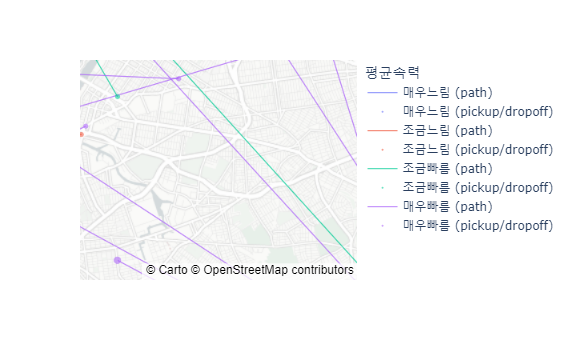

In [258]:
fig3.show()

In [107]:
# for i in range(150):
#     print(fig3.data[i])

fig3.data[i]['legendgroup'] = fig3.data[i]['legendgroup'] + ' (path)'

'매우느림 (path)'

In [108]:
fig3.data[0]

Scattermapbox({
    'hovertemplate': '평균속력=매우느림<br>id=id1891478<br>latitude=%{lat}<br>longitude=%{lon}<extra></extra>',
    'lat': array([40.75983047, 40.75983047]),
    'legendgroup': '매우느림',
    'line': {'color': '#636efa', 'width': 1},
    'lon': array([-73.97090149, -73.97090149]),
    'mode': 'lines',
    'name': '매우느림',
    'opacity': 0.8,
    'showlegend': True,
    'subplot': 'mapbox'
})

In [113]:
for i in range(150):
    if fig3.data[i].mode == 'lines':
        fig3.data[i]['legendgroup'] + ' (path)'
    else:
        fig3.data[i]['legendgroup'] + ' (pickup/dropoff)'

In [112]:
len(fig3.data)

150